# Aprendendo sobre a dimensão das coisas

# O experimento de Eratóstenes

::::{aside}
    :::{image} ../images/people/eratosthenes.png
    :alt: Eratostenes
    :width: 80px
    :::
::::

:::{figure} ../images/cap_01/eratosthenes.jpg
:width: 70 %
:alt: map to buried treasure

Uma ideia sensacional. Créditos da figura [^1]
[^1]: https://images.fineartamerica.com/images-medium-large-5/eratosthenes-experiment-science-photo-library.jpg
:::

Vamos reproduzir a experiência de Eratóstenes com a ajuda do computador, assim não vamos precisar contar os nossos passos em uma viagem de mais de 800 km. Embora a experiência pareça bem simples, existe uma riqueza de sutilezas que devem ser consideradas, e muito o que aprender.

:::{note}
:class: 
:name: roteiro-eratostenes

1. Vamos obter as coordenadas geográficas das cidades de Alexandria e Aswan.
   1. Vamos usar a biblioteca `osmnx` para obter os objetos `geocode` como coordenadas **Lat** e **Lon**. 
2. Utilizando `geopy` podemos obter a distância geodésica entre as duas cidades de maneira bastante direta.
3. Vamos escolher o ano $200 ac$ para nosso experimento, uma época em que o idealizador estava vivo.
4. Precisamos determinar o dia do solstício de verão.
   1. Vamos utilizar a biblioteca `skyfield` para realizar os cálculos astronômicos.
   2. Precisamos de informações sobre as posições do Sol e da Terra neste ano.
      1. O serviço de efemérides [JPL/NASA](https://naif.jpl.nasa.gov/naif/)  pode fornecer os dados que queremos.
5. Precisamos determinar o meio-dia local nas duas cidades.
   1. Já temos como calcular a posição do Sol, vamos determinar as passagens do Sol pelo meridiano local.
6. A partir do meio-dia em Aswan, vamos contruir um vetor de tempos com duração de duas horas e examinar o tamanho da sombra projetada pelo Sol nas duas cidades.
   1. $$ \mathcal{L} = \frac{h}{\mathrm{Alt_\odot}} $$
7. Vamos fazer uma visualização em 3D para ver como seria a sombra no chão.
8. Vamos fazer um gráfico com o tamanho das sombras.
9. Vamos obter uma estimativa do radio da Terra fazendo a mesma suposição de eratóstenes.
10. Vamos agora fazer um raciocínio inverso e usar nossos dados para obter a latitude e longitude e a partir destas informações calcular o Raio da Terra levando em conta as posições reais das cidades, que poderiam ser medidas na época antiga se houvessem relógios confiáveis.
:::

In [1]:
import pyvista as pv
from astroufcg.medidas_historicas.eratostenes import set_experiment, view_shadow_length, view_shadow_3D
import pyvista as pv
pv.set_jupyter_backend('trame')

In [2]:
alexandria = "alexandria, egypt"
aswan = "aswan, egypt"
df = set_experiment(alexandria, aswan, year=-200, object_height=10)

In [3]:
p = pv.Plotter(notebook=True, lighting=None)
p.renderer.shadow_map_resolution = 2048  #
p = view_shadow_3D("alexandria", df, prefix="01", p=p)
p.show()

Widget(value='<iframe src="http://localhost:36185/index.html?ui=P_0x707a0a400bf0_0&reconnect=auto" class="pyvi…

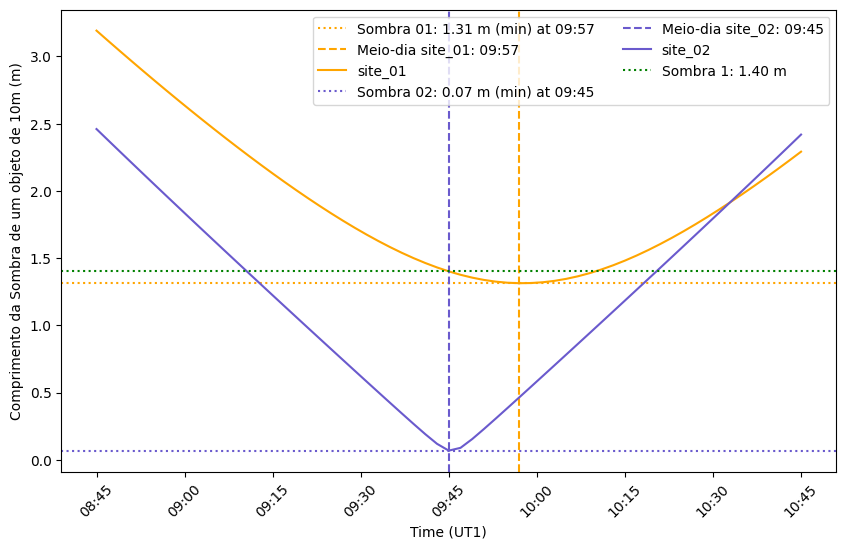

In [4]:
view_shadow_length(df)

In [5]:
from geopy.distance import geodesic, great_circle
import osmnx as ox
import numpy as np
from rich.console import Console
from rich.table import Table
h = 10
alexandria_coords = ox.geocode(alexandria)
aswan_coords = ox.geocode(aswan)
distance = geodesic(alexandria_coords, aswan_coords).km
great_circle_distance = great_circle(alexandria_coords, aswan_coords).km

noon_aswan = df["time_02"].iloc[df.reset_index()["shadow_length_02"].idxmin()]
noon_alexandria = df["time_02"].iloc[df.reset_index()["shadow_length_01"].idxmin()]

shadow_length_01 = df[df.time_02==noon_aswan]["shadow_length_01"].values[0]
shadow_length_02 = df[df.time_02==noon_aswan]["shadow_length_02"].values[0]
min_shadow_01 = df[df.time_02==noon_alexandria]["shadow_length_01"].values[0]

sol_coords_01 = df[df.time_02==noon_aswan][["alt_01", "az_01"]].values[0]
sol_coords_02 = df[df.time_02==noon_aswan][["alt_02", "az_02"]].values[0]
sol_coords_a = df[df.time_02==noon_alexandria][["alt_01", "az_01"]].values[0]

theta_alexandria = np.arctan(shadow_length_01 / h)  # Assuming object height is 10
theta_aswan = np.arctan(shadow_length_02 / h)  # Assuming object height is 10

R_terra = distance / theta_alexandria


In [6]:
table = Table(title="Experimento de Erathostenes")

table.add_column("Grandezas", justify="right", style="cyan", no_wrap=True)
table.add_column("Alexandria", style="yellow")
table.add_column("Aswann", justify="right", style="green")

table.add_row("meio-dia", noon_alexandria.strftime("%H:%M"), noon_aswan.strftime("%H:%M"))
table.add_row("coordenadas", str(alexandria_coords), str(aswan_coords))
table.add_row("sombra", f"{shadow_length_01:.2f} m", f"{shadow_length_02:.2f} m")
table.add_row("ângulo", f"{np.degrees(theta_alexandria):.2f}°", f"{np.degrees(theta_aswan):.2f}°")
table.add_row("Sol meio-dia", f"alt: {sol_coords_a[0]:.2f}°, az: {sol_coords_a[1]:.2f}°", f"alt: {sol_coords_02[0]:.2f}°, az: {sol_coords_02[1]:.2f}°")
table.add_row("Sol meio-dia aswan", f"alt: {sol_coords_01[0]:.2f}°, az: {sol_coords_01[1]:.2f}°", f"alt: {sol_coords_02[0]:.2f}°, az: {sol_coords_02[1]:.2f}°")
d_theta = np.degrees(theta_aswan - theta_alexandria)
d_phi = np.abs((noon_alexandria - noon_aswan).total_seconds()) * 24 / 3600  # Convertendo de segundos para horas
console = Console()
console.print(table)


                        Experimento de Erathostenes                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Grandezas ┃ Alexandria               ┃                   Aswann ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           meio-dia │ 09:57                    │                    09:45 │
│        coordenadas │ (31.1991806, 29.8951716) │   (24.091071, 32.897306) │
│             sombra │ 1.40 m                   │                   0.07 m │
│             ângulo │ 7.98°                    │                    0.39° │
│       Sol meio-dia │ alt: 82.52°, az: 179.12° │ alt: 89.61°, az: 163.38° │
│ Sol meio-dia aswan │ alt: 82.02°, az: 158.93° │ alt: 89.61°, az: 163.38° │
└────────────────────┴──────────────────────────┴──────────────────────────┘

A diferença de Latitude é a diferença de altura do Sol nos dois locais, medidos na mesma hora.

In [7]:
# O sinal é porque a altitude do sol é 90 menos o angulo da sombra
delta_lat = float(-(sol_coords_a - sol_coords_02)[0])
console.print(f"Delta latitude: {delta_lat:.2f}°")

Delta latitude: 7.09°

A diferença de longitude é a diferença de tempo para as passagens no meridiano, convertida em horas.
Falta apenas calcular o tempo em Alexandria.

In [8]:
# O sinal esta relacionado com a rotação da terra
delta_t = (noon_alexandria - noon_aswan).total_seconds()
# Convertendo em graus
delta_lon = float(-delta_t * 360 / (24 * 3600))  # 24 hours in seconds
console.print(f"Delta longitude: {delta_lon:.2f}°")

Delta longitude: -3.00°

Comparando com os dados geográficos temos: 

In [9]:
def format_list(lst):
    return ", ".join(f"{x:.2f}" for x in lst)

delta_coords_astro = [delta_lat, delta_lon]
delta_coords_geo = [alexandria_coords[0] - aswan_coords[0], alexandria_coords[1] - aswan_coords[1]]
console.print(f"Delta coordenadas astronômicas: {format_list(delta_coords_astro)}")
console.print(f"Delta coordenadas geográficas: {format_list(delta_coords_geo)}")

Delta coordenadas astronômicas: 7.09, -3.00

Delta coordenadas geográficas: 7.11, -3.00

## Correções ao Experimento

Precisamos considerar que: 
- ‼️O tamanho da sombra em Aswan não é zero, sua latitude não é no trópico de câncer.
- ‼️A longitude das cidades não é a mesma.

Para dois pontos na esfera, a distância entre eles é dada pela fórmula de Haversine

$$ D(x, y) = 2 \mathrm{arcsen}\left[ \sqrt{\sin^2\left(\frac{x_{lat} - y_{lat}}{2}\right) + \cos(x_{lat})\cos({y_{lat}}) \sin^2\left(\frac{x_{lon} - y_{lon}}{2}\right)} \right]
$$

A diferença de longitude é a diferença de tempo para as passagens no meridiano, convertida em horas.
Falta apenas calcular o tempo em Alexandria.

Não temos como saber as coordenadas exatas, vamos colocar a origem em Alexandra e determinar as coordenadas relativas de Aswan:

In [10]:
lat_alexandria, lon_alexandria = (0, 0)
lat_aswan, lon_aswan = (delta_lat, delta_lon)

In [11]:
R_terra_corrected = great_circle_distance / (2 * np.arcsin( np.sqrt( np.sin(np.radians((lat_alexandria - lat_aswan) / 2))**2 + np.cos(np.radians(lat_alexandria)) * np.cos(np.radians(lat_aswan)) * np.sin(np.radians((lon_alexandria - lon_aswan) / 2))**2)))

In [15]:
import astropy.constants as const
R_terra_earth = const.R_earth.value / 1000  # Convertendo para km

results = Table(title="Raio da Terra")

results.add_column("Grandezas", justify="right", style="cyan", no_wrap=True)
results.add_column("Valor", justify="left", style="yellow", no_wrap=True)

results.add_row("Raio da Terra (Eratóstenes)", f"{R_terra:.2f} km")
results.add_row("Correção de Lat/Lon", f"{R_terra_corrected:.2f} km")
results.add_row("Valor WSG84",  f"{R_terra_earth:.2f} km")
results.add_row("Diferença (Corrigido - Nominal)", f"{R_terra_corrected - R_terra_earth:.2f} km")
results.add_row("Diferença (Eratostenes - Nominal)", f"{R_terra - R_terra_earth:.2f} km")
results.add_row("Diferença porcentual (corrigido)", f"{((R_terra_corrected - R_terra_earth) / R_terra_earth) * 100:.2f}%")
results.add_row("Diferença porcentual (Eratostenes)", f"{((R_terra - R_terra_earth) / R_terra_earth) * 100:.2f}%")

console.print(results)

                   Raio da Terra                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃                          Grandezas ┃ Valor      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│        Raio da Terra (Eratóstenes) │ 6042.50 km │
│                Correção de Lat/Lon │ 6279.87 km │
│                        Valor WSG84 │ 6378.10 km │
│    Diferença (Corrigido - Nominal) │ -98.23 km  │
│  Diferença (Eratostenes - Nominal) │ -335.60 km │
│   Diferença porcentual (corrigido) │ -1.54%     │
│ Diferença porcentual (Eratostenes) │ -5.26%     │
└────────────────────────────────────┴────────────┘